## Input text genarators

### Mongo storage

In [1]:
from typing import Generator
import pymongo


class MongoStorage:
    """Class for working with MongoDB"""

    db: pymongo.database.Database
    col: pymongo.collection.Collection

    def __init__(self, db: pymongo.database.Database, col: pymongo.collection.Collection):
        self.db = db
        self.col = col

    @classmethod
    def connect(cls, host: str, port=27017, db_name='wiki', col_name='articles'):
        db = pymongo.MongoClient(host, port, unicode_decode_error_handler='ignore')[db_name]
        return cls(
            db=db,
            col=db[col_name])

    def get_articles(self, count=0) -> list:
        return list(self.col.find({}).limit(count))

    def get_articles_gen(self, count=0) -> Generator:
        return self.col.find({}).limit(count)

    def get_article(self, title) -> dict:
        doc = self.col.find_one({'title': title})
        return doc if doc else {}

    def get_articles_headings_texts(self, count=0) -> list:
        articles = self.get_articles(count)
        return [article['text']['Заголовок']['text'] for article in articles]

    def get_articles_headings_texts_gen(self, count=0) -> list:
        for article in self.get_articles_gen(count):
            yield article['text']['Заголовок']['text']


### Postgres storage

In [2]:
from typing import Generator
import psycopg2


class PostgresStorage:

    def __init__(self, conn):
        self.conn = conn
        self.cursor = conn.cursor()

    @staticmethod
    def connect(host, port=5432, user='postgres', password='password', dbname='habr'):
        return PostgresStorage(conn=psycopg2.connect(
            host=host, port=port, user=user, password=password, dbname=dbname)
        )

    def get_posts(self, habs_list: list = None, tags_list: list = None, count=0) -> Generator:
        if not habs_list and not tags_list:
            sql = 'SELECT * FROM posts'
            sql = sql + ' LIMIT %d' % count if count > 0 else sql
            self.cursor.execute(sql)
        elif habs_list:
            self.__get_posts_by_habs(habs_list, count)
        elif tags_list:
            self.__get_posts_by_tags(tags_list, count)
        posts_gen = (post for post in self.cursor.fetchall())
        return posts_gen

    def get_posts_texts(self, habs_list: list = None, tags_list: list = None, count=0) -> Generator:
        posts_texts_gen = (post[2] for post in self.get_posts(habs_list, tags_list, count))
        return posts_texts_gen

    def __get_posts_by_habs(self, habs_list: list, count=0) -> None:
        sql = '''SELECT P.* 
                   FROM posts P JOIN habs H ON P.post_id = H.post_id
                  WHERE H.hab in (%s)''' % ''.join(["'" + str(hab) + "', " for hab in habs_list])[:-2]
        sql = sql + " LIMIT %d" % count if count > 0 else sql
        self.cursor.execute(sql)

    def __get_posts_by_tags(self, tags_list: list, count=0) -> None:
        sql = '''SELECT P.* 
                   FROM posts P JOIN tags T ON P.post_id = T.post_id
                  WHERE T.tag in (%s)''' % ''.join(["'" + str(tag) + "', " for tag in tags_list])[:-2]
        sql = sql + " LIMIT %d" % count if count > 0 else sql
        self.cursor.execute(sql)


### Text processors

In [3]:
import re
from typing import Generator
import nltk


class Tokenizer:
    to_sentences = re.compile(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s')
    remove_brackets = re.compile(r' \((.*?)\)')
    remove_punctuation = re.compile(r'[^a-zA-Zа-яА-Я ]')

    @classmethod
    def tokenize(cls, text: str, remove_punctuation=True, remove_brackets=True) -> Generator:
        buf = text.split('\n')
        buf = (item for item in buf if item)
        sentences = (sentence[:-1].lower()
                     for sentence in cls.to_sentences.split(' '.join(buf))
                     if sentence[:-1])
        if remove_brackets:
            sentences = (cls.remove_brackets.sub('', sentence) for sentence in sentences)
        if remove_punctuation:
            return (cls.remove_punctuation.sub('', sentence) for sentence in sentences)
        return sentences


class TextProcessor:
    tokenizer = Tokenizer()

    @classmethod
    def __get_sentences_list(cls, text_list: list, remove_punctuation=True, remove_brackets=True) -> list:
        sentences_list = []
        for text in text_list:
            sentences_list += list(cls.tokenizer.tokenize(
                text=text,
                remove_punctuation=remove_punctuation,
                remove_brackets=remove_brackets))
        return sentences_list

    @classmethod
    def get_sentences_gens(cls, text_gen: Generator, remove_punctuation=True, remove_brackets=True) -> Generator:
        for text in text_gen:
            yield cls.tokenizer.tokenize(
                text=text,
                remove_punctuation=remove_punctuation,
                remove_brackets=remove_brackets)

    @classmethod
    def process_text_list(cls, text_list: list, window_size=1) -> str:
        text = ''
        sentences_list = cls.__get_sentences_list(text_list)
        for sentence_num in range(len(sentences_list)):
            sentence = sentences_list[sentence_num]
            for i in range(window_size):
                text += (' '.join(sentence.split()[i:]) + '\n')
        return text[:-1]
    
    @classmethod
    def get_text_gen(cls, text_gens_gen: Generator) -> Generator:
        for text_gen in text_gens_gen:
            for sentences_gen in cls.get_sentences_gens(text_gen):
                for sentence in sentences_gen:
                    yield sentence

    @classmethod
    def get_text_gen_2(cls, text_gens_gen: Generator, window_size=1) -> Generator:
        for text_gen in text_gens_gen:
            for sentences_gen in cls.get_sentences_gens(text_gen):
                for sentence in sentences_gen:
                    for ngram in (' '.join(ngram) for ngram in nltk.ngrams(sentence.split(), window_size)):
                        yield ngram

    @classmethod
    def process_text_gen(cls, text_gens_gen: Generator, window_size=1) -> str:
        text = ''
        for sentence in cls.get_text_gen(
                text_gens_gen=text_gens_gen,
                window_size=window_size):
            text += (sentence + '\n')
        return text[:-1]


## Encoded markov chain model

### Chain realization

In [4]:
import random
import operator
import bisect
import json
import copy

# Python3 compatibility
try: # pragma: no cover
    basestring
except NameError: # pragma: no cover
    basestring = str

BEGIN = 0
END = -1

def accumulate(iterable, func=operator.add):
    """
    Cumulative calculations. (Summation, by default.)
    Via: https://docs.python.org/3/library/itertools.html#itertools.accumulate
    """
    it = iter(iterable)
    total = next(it)
    yield total
    for element in it:
        total = func(total, element)
        yield total

def compile_next(next_dict):
    words = list(next_dict.keys())
    cff = list(accumulate(next_dict.values()))
    return [words, cff]

class EncodedChain(object):
    """
    A Markov chain representing processes that have both beginnings and ends.
    For example: Sentences.
    """
    def __init__(self, corpus, state_size, model=None):
        """
        `corpus`: A list of lists, where each outer list is a "run"
        of the process (e.g., a single sentence), and each inner list
        contains the steps (e.g., words) in the run. If you want to simulate
        an infinite process, you can come very close by passing just one, very
        long run.

        `state_size`: An integer indicating the number of items the model
        uses to represent its state. For text generation, 2 or 3 are typical.
        """
        self.state_size = state_size
        self.model = model or self.build(corpus, self.state_size)
        self.compiled = (len(self.model) > 0) and (type(self.model[tuple([BEGIN]*state_size)]) == list)
        if not self.compiled:
            self.precompute_begin_state()

    def compile(self, inplace = False):
        if self.compiled:
            if inplace: return self
            return EncodedChain(None, self.state_size, model = copy.deepcopy(self.model))
        mdict = { state: compile_next(next_dict) for (state, next_dict) in self.model.items() }
        if not inplace: return EncodedChain(None, self.state_size, model = mdict)
        self.model = mdict
        self.compiled = True
        return self

    def build(self, corpus, state_size):
        """
        Build a Python representation of the Markov model. Returns a dict
        of dicts where the keys of the outer dict represent all possible states,
        and point to the inner dicts. The inner dicts represent all possibilities
        for the "next" item in the chain, along with the count of times it
        appears.
        """

        # Using a DefaultDict here would be a lot more convenient, however the memory
        # usage is far higher.
        model = {}

        for run in corpus:
            items = ([ BEGIN ] * state_size) + run + [ END ]
            for i in range(len(run) + 1):
                state = tuple(items[i:i+state_size])
                follow = items[i+state_size]
                if state not in model:
                    model[state] = {}

                if follow not in model[state]:
                    model[state][follow] = 0

                model[state][follow] += 1
        return model

    def precompute_begin_state(self):
        """
        Caches the summation calculation and available choices for BEGIN * state_size.
        Significantly speeds up chain generation on large corpora. Thanks, @schollz!
        """
        begin_state = tuple([ BEGIN ] * self.state_size)
        choices, cumdist = compile_next(self.model[begin_state])
        self.begin_cumdist = cumdist
        self.begin_choices = choices

    def move(self, state):
        """
        Given a state, choose the next item at random.
        """
        if self.compiled:
            choices, cumdist = self.model[state]
        elif state == tuple([ BEGIN ] * self.state_size):
            choices = self.begin_choices
            cumdist = self.begin_cumdist
        else:
            choices, weights = zip(*self.model[state].items())
            cumdist = list(accumulate(weights))
        r = random.random() * cumdist[-1]
        selection = choices[bisect.bisect(cumdist, r)]
        return selection

    def gen(self, init_state=None):
        """
        Starting either with a naive BEGIN state, or the provided `init_state`
        (as a tuple), return a generator that will yield successive items
        until the chain reaches the END state.
        """
        state = init_state or (BEGIN,) * self.state_size
        while True:
            next_word = self.move(state)
            # if next_word == END: break
            
            yield next_word
            state = tuple(state[1:]) + (next_word,)

    def walk(self, init_state=None):
        """
        Return a list representing a single run of the Markov model, either
        starting with a naive BEGIN state, or the provided `init_state`
        (as a tuple).
        """
        return list(self.gen(init_state))

    def to_json(self):
        """
        Dump the model as a JSON object, for loading later.
        """
        return json.dumps(list(self.model.items()))

    @classmethod
    def from_json(cls, json_thing):
        """
        Given a JSON object or JSON string that was created by `self.to_json`,
        return the corresponding markovify.Chain.
        """

        if isinstance(json_thing, basestring):
            obj = json.loads(json_thing)
        else:
            obj = json_thing

        if isinstance(obj, list):
            rehydrated = dict((tuple(item[0]), item[1]) for item in obj)
        elif isinstance(obj, dict):
            rehydrated = obj
        else:
            raise ValueError("Object should be dict or list")

        state_size = len(list(rehydrated.keys())[0])

        inst = cls(None, state_size, rehydrated)
        return inst


In [5]:
train_text = 'предложение для проверки работы для библиотеки для\nеще одно предложение для работы\nработы очень много\nбиблиотеки для работы очень интересны\nпредложение очень работы\nодно очень библиотеки'

def process_text(text: str) -> list:
    return [sent.split() for sent in text.split('\n')]

process_text(train_text)

[['предложение', 'для', 'проверки', 'работы', 'для', 'библиотеки', 'для'],
 ['еще', 'одно', 'предложение', 'для', 'работы'],
 ['работы', 'очень', 'много'],
 ['библиотеки', 'для', 'работы', 'очень', 'интересны'],
 ['предложение', 'очень', 'работы'],
 ['одно', 'очень', 'библиотеки']]

In [6]:
chain = EncodedChain(process_text(train_text), state_size=2)

In [7]:
encoded_corpus = [
    [1, 5, 6],
    [65, 4, 1, 54],
    [5, 65, 1, 324],
    [3, 6, 54]
]

chain = EncodedChain(encoded_corpus, state_size=2)

In [8]:
chain.model

{(0, 0): {1: 1, 65: 1, 5: 1, 3: 1},
 (0, 1): {5: 1},
 (1, 5): {6: 1},
 (5, 6): {-1: 1},
 (0, 65): {4: 1},
 (65, 4): {1: 1},
 (4, 1): {54: 1},
 (1, 54): {-1: 1},
 (0, 5): {65: 1},
 (5, 65): {1: 1},
 (65, 1): {324: 1},
 (1, 324): {-1: 1},
 (0, 3): {6: 1},
 (3, 6): {54: 1},
 (6, 54): {-1: 1}}

In [9]:
compiled_chain = chain.compile()
compiled_chain.model

{(0, 0): [[1, 65, 5, 3], [1, 2, 3, 4]],
 (0, 1): [[5], [1]],
 (1, 5): [[6], [1]],
 (5, 6): [[-1], [1]],
 (0, 65): [[4], [1]],
 (65, 4): [[1], [1]],
 (4, 1): [[54], [1]],
 (1, 54): [[-1], [1]],
 (0, 5): [[65], [1]],
 (5, 65): [[1], [1]],
 (65, 1): [[324], [1]],
 (1, 324): [[-1], [1]],
 (0, 3): [[6], [1]],
 (3, 6): [[54], [1]],
 (6, 54): [[-1], [1]]}

### Words encoder

In [10]:
import json
from typing import Generator
        
class WordsEncoder:
    counter: int
    word2int: dict
    int2word: dict

    def __init__(self, text_corpus, counter=None, word2int=None, int2word=None):
        if not text_corpus:
            self.counter = counter
            self.word2int = word2int
            self.int2word = int2word
        else:
            self.counter = 0
            self.word2int = {
                BEGIN: 0,
                END: -1
            }
            self.int2word = {
                0: BEGIN,
                -1: END
            }
            is_gen = isinstance(text_corpus, Generator)
            for sentence in text_corpus:
                if is_gen:
                    sentence = sentence.split()
                for word in sentence:
                    if word not in self.word2int:
                        self.counter += 1
                        self.word2int[word] = self.counter
                        self.int2word[self.counter] = word

    def encode_words_list(self, words_list: list) -> list:
        return [self.word2int[word] for word in words_list]

    def encode_text_corpus(self, text_corpus: list) -> list:
        """List of lists of words"""
        return [self.encode_words_list(words_list) for words_list in text_corpus]

    def encode_text_corpus_gen(self, text_corpus_gen: Generator) -> Generator:
        """List of lists of words"""
        return (self.encode_words_list(sentence.split()) for sentence in text_corpus_gen)

    def decode_codes_list(self, codes_list: list) -> list:
        return [self.int2word[code] for code in codes_list]

    def to_dict(self):
        """
        Returns the underlying data as a Python dict.
        """
        return {
            "counter": self.counter,
            "word2int": self.word2int,
            "int2word": self.int2word
        }

    def to_json(self):
        """
        Returns the underlying data as a JSON string.
        """
        return json.dumps(self.to_dict())

    @classmethod
    def from_dict(cls, obj):

        int2word = obj["int2word"]
        for key in int2word:
            int2word[int(key)] = int2word.pop(key)

        int2word[END] = END
        int2word[BEGIN] = BEGIN

        word2int = obj["word2int"]
        word2int[END] = int(word2int.pop(str(END)))
        word2int[BEGIN] = int(word2int.pop(str(BEGIN)))

        return cls(
            None,
            counter=obj["counter"],
            word2int=word2int,
            int2word=int2word
        )

    @classmethod
    def from_json(cls, json_str):
        return cls.from_dict(json.loads(json_str))

In [11]:
text_corpus = process_text(train_text)
encoder = WordsEncoder(text_corpus)
encoder.word2int

{0: 0,
 -1: -1,
 'предложение': 1,
 'для': 2,
 'проверки': 3,
 'работы': 4,
 'библиотеки': 5,
 'еще': 6,
 'одно': 7,
 'очень': 8,
 'много': 9,
 'интересны': 10}

In [12]:
s = encoder.to_json()
s

'{"counter": 10, "word2int": {"0": 0, "-1": -1, "\\u043f\\u0440\\u0435\\u0434\\u043b\\u043e\\u0436\\u0435\\u043d\\u0438\\u0435": 1, "\\u0434\\u043b\\u044f": 2, "\\u043f\\u0440\\u043e\\u0432\\u0435\\u0440\\u043a\\u0438": 3, "\\u0440\\u0430\\u0431\\u043e\\u0442\\u044b": 4, "\\u0431\\u0438\\u0431\\u043b\\u0438\\u043e\\u0442\\u0435\\u043a\\u0438": 5, "\\u0435\\u0449\\u0435": 6, "\\u043e\\u0434\\u043d\\u043e": 7, "\\u043e\\u0447\\u0435\\u043d\\u044c": 8, "\\u043c\\u043d\\u043e\\u0433\\u043e": 9, "\\u0438\\u043d\\u0442\\u0435\\u0440\\u0435\\u0441\\u043d\\u044b": 10}, "int2word": {"0": 0, "-1": -1, "1": "\\u043f\\u0440\\u0435\\u0434\\u043b\\u043e\\u0436\\u0435\\u043d\\u0438\\u0435", "2": "\\u0434\\u043b\\u044f", "3": "\\u043f\\u0440\\u043e\\u0432\\u0435\\u0440\\u043a\\u0438", "4": "\\u0440\\u0430\\u0431\\u043e\\u0442\\u044b", "5": "\\u0431\\u0438\\u0431\\u043b\\u0438\\u043e\\u0442\\u0435\\u043a\\u0438", "6": "\\u0435\\u0449\\u0435", "7": "\\u043e\\u0434\\u043d\\u043e", "8": "\\u043e\\u0447\\u

In [13]:
WordsEncoder.from_json(s).to_dict()

{'counter': 10,
 'word2int': {'предложение': 1,
  'для': 2,
  'проверки': 3,
  'работы': 4,
  'библиотеки': 5,
  'еще': 6,
  'одно': 7,
  'очень': 8,
  'много': 9,
  'интересны': 10,
  -1: -1,
  0: 0},
 'int2word': {'9': 'много',
  '10': 'интересны',
  0: 0,
  -1: -1,
  1: 'предложение',
  2: 'для',
  3: 'проверки',
  4: 'работы',
  5: 'библиотеки',
  6: 'еще',
  8: 'очень',
  7: 'одно'}}

In [14]:
encoder.encode_text_corpus(text_corpus)

[[1, 2, 3, 4, 2, 5, 2],
 [6, 7, 1, 2, 4],
 [4, 8, 9],
 [5, 2, 4, 8, 10],
 [1, 8, 4],
 [7, 8, 5]]

In [15]:
print('Sentence: ', text_corpus[1])
encoded_sentence = encoder.encode_words_list(text_corpus[1])
print('Encoding sentence: ', encoded_sentence)
print('Decoded sentence: ', encoder.decode_codes_list([6, 7, 1]))

Sentence:  ['еще', 'одно', 'предложение', 'для', 'работы']
Encoding sentence:  [6, 7, 1, 2, 4]
Decoded sentence:  ['еще', 'одно', 'предложение']


### Text generator model based on encoded markov chain

In [16]:
import re
import json
import random
from markovify.splitters import split_into_sentences
from unidecode import unidecode

DEFAULT_MAX_OVERLAP_RATIO = 0.7
DEFAULT_MAX_OVERLAP_TOTAL = 15
DEFAULT_TRIES = 10


class ParamError(Exception):
    pass


class EncodedText(object):

    encoder: WordsEncoder

    reject_pat = re.compile(r"(^')|('$)|\s'|'\s|[\"(\(\)\[\])]")

    def __init__(self, input_text, state_size=2, chain=None, parsed_sentences=None, retain_original=True,
                 well_formed=True, reject_reg='', encoder=None):
        """
        input_text: A string.
        state_size: An integer, indicating the number of words in the self's state.
        chain: A trained markovify.Chain instance for this text, if pre-processed.
        parsed_sentences: A list of lists, where each outer list is a "run"
              of the process (e.g. a single sentence), and each inner list
              contains the steps (e.g. words) in the run. If you want to simulate
              an infinite process, you can come very close by passing just one, very
              long run.
        retain_original: Indicates whether to keep the original corpus.
        well_formed: Indicates whether sentences should be well-formed, preventing
              unmatched quotes, parenthesis by default, or a custom regular expression
              can be provided.
        reject_reg: If well_formed is True, this can be provided to override the
              standard rejection pattern.
        """
        self.well_formed = well_formed
        if well_formed and reject_reg != '':
            self.reject_pat = re.compile(reject_reg)

        self.state_size = state_size
        if encoder:
            self.retain_original = None
            self.encoder = encoder
            if chain:
                self.chain = chain
            elif isinstance(input_text, Generator):
                self.chain = EncodedChain(input_text, state_size)
        else:
            can_make_sentences = parsed_sentences is not None or input_text is not None
            self.retain_original = retain_original and can_make_sentences
            if self.retain_original:
                self.parsed_sentences = parsed_sentences or list(self.generate_corpus(input_text))

                # Rejoined text lets us assess the novelty of generated sentences
                self.rejoined_text = self.sentence_join(map(self.word_join, self.parsed_sentences))
                self.encoder = WordsEncoder(self.parsed_sentences)
                encoded_corpus = self.encoder.encode_text_corpus(self.parsed_sentences)
                self.chain = chain or EncodedChain(encoded_corpus, state_size)
            else:
                if not chain:
                    parsed = parsed_sentences or self.generate_corpus(input_text)
                    self.encoder = WordsEncoder(parsed)
                    encoded_corpus = self.encoder.encode_text_corpus(parsed)
                self.chain = chain or EncodedChain(encoded_corpus, state_size)

    def compile(self, inplace=False):
        if inplace:
            self.chain.compile(inplace=True)
            return self
        cchain = self.chain.compile(inplace=False)
        psent = None
        if hasattr(self, 'parsed_sentences'):
            psent = self.parsed_sentences
        return EncodedText(None,
                           state_size=self.state_size,
                           chain=cchain,
                           parsed_sentences=psent,
                           retain_original=self.retain_original,
                           well_formed=self.well_formed,
                           reject_reg=self.reject_pat)

    def to_dict(self):
        """
        Returns the underlying data as a Python dict.
        """
        return {
            "state_size": self.state_size,
            "chain": self.chain.to_json(),
            "parsed_sentences": self.parsed_sentences if self.retain_original else None,
            "encoder": self.encoder.to_json()
        }

    def to_json(self):
        """
        Returns the underlying data as a JSON string.
        """
        return json.dumps(self.to_dict())

    @classmethod
    def from_dict(cls, obj, **kwargs):
        return cls(
            None,
            state_size=obj["state_size"],
            chain=EncodedChain.from_json(obj["chain"]),
            parsed_sentences=obj.get("parsed_sentences"),
            encoder=WordsEncoder.from_json(obj["encoder"])
        )

    @classmethod
    def from_json(cls, json_str):
        return cls.from_dict(json.loads(json_str))

    def sentence_split(self, text):
        """
        Splits full-text string into a list of sentences.
        """
        return split_into_sentences(text)

    def sentence_join(self, sentences):
        """
        Re-joins a list of sentences into the full text.
        """
        return " ".join(sentences)

    word_split_pattern = re.compile(r"\s+")

    def word_split(self, sentence):
        """
        Splits a sentence into a list of words.
        """
        return re.split(self.word_split_pattern, sentence)

    def word_join(self, words):
        """
        Re-joins a list of words into a sentence.
        """
        return " ".join(words)

    def test_sentence_input(self, sentence):
        """
        A basic sentence filter. The default rejects sentences that contain
        the type of punctuation that would look strange on its own
        in a randomly-generated sentence.
        """
        if len(sentence.strip()) == 0: return False
        # Decode unicode, mainly to normalize fancy quotation marks
        if sentence.__class__.__name__ == "str":  # pragma: no cover
            decoded = sentence
        else:  # pragma: no cover
            decoded = unidecode(sentence)
        # Sentence shouldn't contain problematic characters
        if self.well_formed and self.reject_pat.search(decoded): return False
        return True

    def generate_corpus(self, text):
        """
        Given a text string, returns a list of lists; that is, a list of
        "sentences," each of which is a list of words. Before splitting into
        words, the sentences are filtered through `self.test_sentence_input`
        """
        if isinstance(text, str):
            sentences = self.sentence_split(text)
        else:
            sentences = []
            for line in text:
                sentences += self.sentence_split(line)
        passing = filter(self.test_sentence_input, sentences)
        runs = map(self.word_split, passing)
        return runs

    def test_sentence_output(self, words, max_overlap_ratio, max_overlap_total):
        """
        Given a generated list of words, accept or reject it. This one rejects
        sentences that too closely match the original text, namely those that
        contain any identical sequence of words of X length, where X is the
        smaller number of (a) `max_overlap_ratio` (default: 0.7) of the total
        number of words, and (b) `max_overlap_total` (default: 15).
        """
        # Reject large chunks of similarity
        overlap_ratio = int(round(max_overlap_ratio * len(words)))
        overlap_max = min(max_overlap_total, overlap_ratio)
        overlap_over = overlap_max + 1
        gram_count = max((len(words) - overlap_max), 1)
        grams = [words[i:i + overlap_over] for i in range(gram_count)]
        for g in grams:
            gram_joined = self.word_join(g)
            if gram_joined in self.rejoined_text:
                return False
        return True

    def make_sentence(self, init_state=None, **kwargs):
        """
        Attempts `tries` (default: 10) times to generate a valid sentence,
        based on the self and `test_sentence_output`. Passes `max_overlap_ratio`
        and `max_overlap_total` to `test_sentence_output`.

        If successful, returns the sentence as a string. If not, returns None.

        If `init_state` (a tuple of `self.chain.state_size` words) is not specified,
        this method chooses a sentence-start at random, in accordance with
        the self.

        If `test_output` is set as False then the `test_sentence_output` check
        will be skipped.

        If `max_words` or `min_words` are specified, the word count for the sentence will be
        evaluated against the provided limit(s).
        """
        tries = kwargs.get('tries', 10)
        mor = kwargs.get('max_overlap_ratio', 0.7)
        mot = kwargs.get('max_overlap_total', 15)
        test_output = kwargs.get('test_output', True)
        max_words = kwargs.get('max_words', None)
        min_words = kwargs.get('min_words', None)

        try:
            if init_state != None:
                init_state = tuple(self.encoder.encode_words_list(init_state))
                prefix = list(init_state)
                for word in prefix:
                    if word == BEGIN:
                        prefix = prefix[1:]
                    else:
                        break
            else:
                prefix = []

            for _ in range(tries):
                words_codes = prefix + self.chain.walk(init_state)
                words = self.encoder.decode_codes_list(words_codes)
                if (max_words != None and len(words) > max_words) or (min_words != None and len(words) < min_words):
                    continue
                if test_output and hasattr(self, "rejoined_text"):
                    if self.test_sentence_output(words, mor, mot):
                        return self.word_join(words)
                else:
                    return self.word_join(words)
        except KeyError:
            pass
        return None

    def make_short_sentence(self, max_chars, min_chars=0, **kwargs):
        """
        Tries making a sentence of no more than `max_chars` characters and optionally
        no less than `min_chars` characters, passing **kwargs to `self.make_sentence`.
        """
        tries = kwargs.get('tries', DEFAULT_TRIES)

        for _ in range(tries):
            sentence = self.make_sentence(**kwargs)
            if sentence and len(sentence) <= max_chars and len(sentence) >= min_chars:
                return sentence

    def make_sentence_with_start(self, beginning, strict=True, **kwargs):
        """
        Tries making a sentence that begins with `beginning` string,
        which should be a string of one to `self.state` words known
        to exist in the corpus.

        If strict == True, then markovify will draw its initial inspiration
        only from sentences that start with the specified word/phrase.

        If strict == False, then markovify will draw its initial inspiration
        from any sentence containing the specified word/phrase.

        **kwargs are passed to `self.make_sentence`
        """
        split = tuple(self.word_split(beginning))
        word_count = len(split)

        if word_count == self.state_size:
            init_states = [split]

        elif word_count > 0 and word_count < self.state_size:
            if strict:
                init_states = [(BEGIN,) * (self.state_size - word_count) + split]

            else:
                init_states = [key for key in self.chain.model.keys()
                               # check for starting with begin as well ordered lists
                               if tuple(filter(lambda x: x != BEGIN, key))[:word_count] == split]

                random.shuffle(init_states)
        else:
            err_msg = "`make_sentence_with_start` for this self requires a string containing 1 to {0} words. Yours has {1}: {2}".format(
                self.state_size, word_count, str(split))
            raise ParamError(err_msg)

        for init_state in init_states:
            output = self.make_sentence(init_state, **kwargs)
            if output is not None:
                return output

        return None

    @classmethod
    def from_chain(cls, chain_json, corpus=None, parsed_sentences=None):
        """
        Init a Text class based on an existing chain JSON string or object
        If corpus is None, overlap checking won't work.
        """
        chain = EncodedChain.from_json(chain_json)
        return cls(corpus or None, parsed_sentences=parsed_sentences, state_size=chain.state_size, chain=chain)


class EncodedNewlineText(EncodedText):
    """
    A (usable) example of subclassing markovify.Text. This one lets you markovify
    text where the sentences are separated by newlines instead of ". "
    """

    def sentence_split(self, text):
        return re.split(r"\s*\n\s*", text)


### Wrapper class for text generator model based on encoded markov chain

In [17]:
import os
from typing import Generator


class MarkovModel:

    model: EncodedText

    def __init__(self, train_input, model=None, encoder=None, state_size=2):
        if model:
            self.model = model
        elif isinstance(train_input, str):
            self.model = EncodedNewlineText(train_input, state_size=state_size)
        elif isinstance(train_input, Generator) and encoder:
            self.model = EncodedText(train_input, state_size=state_size, encoder=encoder)

    def compile(self):
        self.model.compile(inplace=True)
        return self

    @classmethod
    def load(cls, model_name='model1.0-habr-10000.json', models_path='models/markov/bin'):
        with open(os.path.join(models_path, model_name), 'r') as f:
            model_json = f.read()
        model = EncodedText.from_json(model_json)
        return cls(None, model=model)

    def save(self, model_name, models_path='models/markov/bin'):
        with open(os.path.join(models_path, model_name), 'w') as f:
            f.write(self.model.to_json())

    def generate_sample(self, beginning: str) -> str:
        return self.model.make_sentence_with_start(beginning)

    def make_sentences_for_t9(self, beginning: str, first_words_count=1, count=20) -> list:
        phrases = set()
        for i in range(count):
            phrase = self.generate_sample(beginning)
            if phrase:
                words_list = phrase.split()
                if len(words_list) > 1:
                    phrases.add(" ".join(words_list[first_words_count:]))
        return list(phrases)



In [79]:
def get_text_gen(
        mongo_storage: MongoStorage,
        postgres_storage: PostgresStorage,
        wiki_articles_count=1000,
        habr_posts_count=1000,
        model_state=3,
        **kwargs
):
    habr_posts_gen = postgres_storage.get_posts_texts(
        count=habr_posts_count, habs_list=kwargs.get('habs_list'), tags_list=kwargs.get('tags_list'))
    wiki_articles_gen = mongo_storage.get_articles_headings_texts_gen(
        count=wiki_articles_count)
    return TextProcessor.get_text_gen(
        text_gens_gen=(text_gen for text_gen in (habr_posts_gen, wiki_articles_gen)))

def get_uncompiled_markov_model(
        mongo_storage: MongoStorage,
        postgres_storage: PostgresStorage,
        wiki_articles_count=1000,
        habr_posts_count=1000,
        model_state=3
):
    habr_posts = postgres_storage.get_posts_texts(
        count=habr_posts_count)
    wiki_articles = mongo_storage.get_articles_headings_texts(
        count=wiki_articles_count)
    input_text = TextProcessor.process_text_list(
        text_list=habr_posts + wiki_articles,
        window_size=model_state)
    model = MarkovModel(input_text, state_size=model_state)
    return model

def get_ram_model(
        mongo_storage: MongoStorage,
        postgres_storage: PostgresStorage,
        wiki_articles_count=1000,
        habr_posts_count=1000,
        model_state=3,
        **kwargs
):
    kwargs = dict(
        mongo_storage=mongo_storage,
        postgres_storage=postgres_storage,
        wiki_articles_count=wiki_articles_count,
        habr_posts_count=habr_posts_count,
        model_state=model_state)
    print('Get posts and articles')
    encoder = WordsEncoder(
        text_corpus=get_text_gen(**kwargs))
    train_corpus = encoder.encode_text_corpus_gen(
        text_corpus_gen=get_text_gen(**kwargs))
    a = 0
    for t in get_text_gen(**kwargs):
        a += len(t)
    print('Get text_gen: ', a)
    model = MarkovModel(
        train_input=train_corpus,
        state_size=model_state,
        encoder=encoder)
    print('Complete training model')
    return model.compile()

### Establish connections to dbs

In [80]:
mongo_storage = MongoStorage.connect(
            host='localhost')
postgres_storage = PostgresStorage.connect(
            host='172.17.0.2')

### Saving & loading model as json

In [83]:
%%timeit
get_ram_model(
    mongo_storage=mongo_storage,
    postgres_storage=postgres_storage,
    wiki_articles_count=1,
    habr_posts_count=100,
    habs_list=['Математика']    
)

Get posts and articles
Get text_gen:  443524
Complete training model
Get posts and articles
Get text_gen:  443524
Complete training model
Get posts and articles
Get text_gen:  443524
Complete training model
Get posts and articles
Get text_gen:  443524
Complete training model
Get posts and articles
Get text_gen:  443524
Complete training model
Get posts and articles
Get text_gen:  443524
Complete training model
Get posts and articles
Get text_gen:  443524
Complete training model
Get posts and articles
Get text_gen:  443524
Complete training model
282 ms ± 3.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [84]:
%%timeit
get_ram_model(
    mongo_storage=mongo_storage,
    postgres_storage=postgres_storage,
    wiki_articles_count=1,
    habr_posts_count=200,
    habs_list=['Математика']    
)

Get posts and articles
Get text_gen:  1020568
Complete training model
Get posts and articles
Get text_gen:  1020568
Complete training model
Get posts and articles
Get text_gen:  1020568
Complete training model
Get posts and articles
Get text_gen:  1020568
Complete training model
Get posts and articles
Get text_gen:  1020568
Complete training model
Get posts and articles
Get text_gen:  1020568
Complete training model
Get posts and articles
Get text_gen:  1020568
Complete training model
Get posts and articles
Get text_gen:  1020568
Complete training model
646 ms ± 4.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
%%timeit
get_ram_model(
    mongo_storage=mongo_storage,
    postgres_storage=postgres_storage,
    wiki_articles_count=1,
    habr_posts_count=50,
    habs_list=['Математика']    
)

Get posts and articles
Get text_gen:  209139
Complete training model
Get posts and articles
Get text_gen:  209139
Complete training model
Get posts and articles
Get text_gen:  209139
Complete training model
Get posts and articles
Get text_gen:  209139
Complete training model
Get posts and articles
Get text_gen:  209139
Complete training model
Get posts and articles
Get text_gen:  209139
Complete training model
Get posts and articles
Get text_gen:  209139
Complete training model
Get posts and articles
Get text_gen:  209139
Complete training model
Get posts and articles
Get text_gen:  209139
Complete training model
Get posts and articles
Get text_gen:  209139
Complete training model
Get posts and articles
Get text_gen:  209139
Complete training model
Get posts and articles
Get text_gen:  209139
Complete training model
Get posts and articles
Get text_gen:  209139
Complete training model
Get posts and articles
Get text_gen:  209139
Complete training model
Get posts and articles
Get text_ge

In [86]:
%%timeit
get_ram_model(
    mongo_storage=mongo_storage,
    postgres_storage=postgres_storage,
    wiki_articles_count=1,
    habr_posts_count=10,
    model_state=3,
    habs_list=['Машинное обучение']    
)

Get posts and articles
Get text_gen:  51261
Complete training model
Get posts and articles
Get text_gen:  51261
Complete training model
Get posts and articles
Get text_gen:  51261
Complete training model
Get posts and articles
Get text_gen:  51261
Complete training model
Get posts and articles
Get text_gen:  51261
Complete training model
Get posts and articles
Get text_gen:  51261
Complete training model
Get posts and articles
Get text_gen:  51261
Complete training model
Get posts and articles
Get text_gen:  51261
Complete training model
Get posts and articles
Get text_gen:  51261
Complete training model
Get posts and articles
Get text_gen:  51261
Complete training model
Get posts and articles
Get text_gen:  51261
Complete training model
Get posts and articles
Get text_gen:  51261
Complete training model
Get posts and articles
Get text_gen:  51261
Complete training model
Get posts and articles
Get text_gen:  51261
Complete training model
Get posts and articles
Get text_gen:  51261
Comp

Text(0, 0.5, 'Скорость обучения, мс')

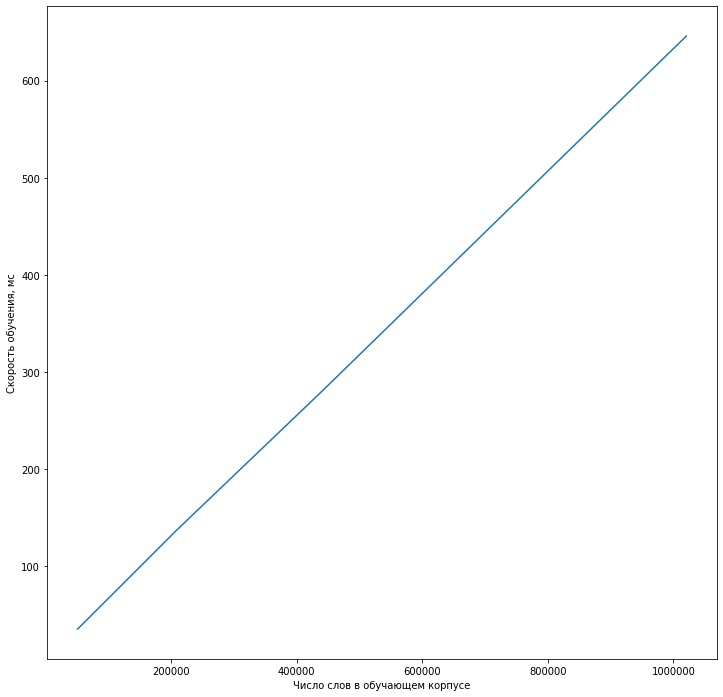

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.plot(np.array([51261, 209139, 443524, 1020568]), np.array([35, 137, 282, 646]))
plt.xlabel('Число слов в обучающем корпусе')
plt.ylabel('Скорость обучения, мс')

In [43]:
model.save('test.json', '')

In [93]:
np.mean(np.array([51261, 209139, 443524, 1020568]) / np.array([10, 50, 100, 200]))

4711.74

In [97]:
2200 * 4800 * (np.mean(np.array([10, 50, 100, 200])) / np.mean(np.array([51261, 209139, 443524, 1020568]))) / 1000

2.20447528895466

In [98]:
2200 * 4800

10560000

In [44]:
model = MarkovModel.load('test.json', '')

In [45]:
model.model.encoder.int2word

{'302': 'спорт',
 '303': 'только',
 '304': 'дело',
 '305': 'жизни',
 '306': 'возможность',
 '307': 'обрести',
 '308': 'друзей',
 '309': 'всего',
 '310': 'мира',
 '311': 'tmhwk',
 '312': 'место',
 '313': 'проведения',
 '314': 'топор',
 '315': 'оружия',
 '316': 'защита',
 '317': 'закаленной',
 '318': 'стальной',
 '319': 'полиэтилена',
 '320': 'высокой',
 '321': 'плотности',
 '322': 'максимальная',
 '323': 'непросроченная',
 '324': 'ч',
 '325': 'система',
 '326': 'gpa',
 '327': 'электроэнергия',
 '328': 'аккумулятор',
 '329': 'литиевый',
 '330': 'полимер',
 '331': 's',
 '332': 'слабых',
 '333': 'сторон',
 '334': 'нет',
 '335': 'dutch',
 '336': 'girls',
 '337': 'хочет',
 '338': 'стать',
 '339': 'образцом',
 '340': 'девочек',
 '341': 'занимающихся',
 '342': 'инженерными',
 '343': 'разработками',
 '344': 'building',
 '345': 'сегодня',
 '346': 'востребовано',
 '347': 'модно',
 '348': 'число',
 '349': 'страна',
 '350': 'нидерланды',
 '351': 'tr',
 '352': 'пневматический',
 '353': 'гранд',
 '35

In [46]:
encoder.int2word

{0: 0,
 -1: -1,
 1: 'предложение',
 2: 'для',
 3: 'проверки',
 4: 'работы',
 5: 'библиотеки',
 6: 'еще',
 7: 'одно',
 8: 'очень',
 9: 'много'}

## Test speed

In [16]:
habr_posts_count = 10000
wiki_articles_count = 10000
model_state = 3

CPU times: user 7.26 ms, sys: 1.66 ms, total: 8.92 ms
Wall time: 540 ms


### Markovify realization - without generators and encoding

In [163]:
%%time

habr_posts = postgres_storage.get_posts_texts(
        count=habr_posts_count)
wiki_articles = mongo_storage.get_articles_headings_texts(
    count=wiki_articles_count)
input_text = TextProcessor.process_text_list(
        text_list=habr_posts + wiki_articles,
        window_size=model_state)

NameError: name 'habr_posts_count' is not defined

In [18]:
%%time

processed_text = process_text(input_text)
encoder = WordsEncoder(processed_text)
encoder.counter

CPU times: user 7.64 s, sys: 450 ms, total: 8.09 s
Wall time: 8.09 s


474252

In [20]:
import markovify

In [21]:
%%time
old_model = markovify.Chain(
    processed_text, 
    state_size=model_state)

CPU times: user 19 s, sys: 623 ms, total: 19.6 s
Wall time: 19.6 s


#### Mem usage: 6.71 - 9.04
For 10k posts & 10k articles

In [22]:
import sys

print('Model size: ', round(sys.getsizeof(old_model.model) / (1024 * 1024), 2), 'MB')
print('Encoder size: ', round((sys.getsizeof(encoder.word2int) + sys.getsizeof(encoder.int2word) + sys.getsizeof(encoder.counter)) / (1024 * 1024), 2), 'MB')

Model size:  320.0 MB
Encoder size:  40.0 MB


In [23]:
del habr_posts
del wiki_articles
del input_text
del processed_text

#### TODO: refs counter in Python - how optimize? 

### Custom realization - with generators and encoding

In [24]:
%%time

def get_text_gen():
    habr_posts_gen = postgres_storage.get_posts_texts(
    count=habr_posts_count)
    wiki_articles_gen = mongo_storage.get_articles_headings_texts_gen(
        count=wiki_articles_count)
    return TextProcessor.get_text_gen(
        text_gens_gen=(text_gen for text_gen in (habr_posts_gen, wiki_articles_gen)),
        window_size=model_state)

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 19.3 µs


In [26]:
%%time

gen_encoder = WordsEncoder(get_text_gen())
train_input = gen_encoder.encode_text_corpus_gen(get_text_gen())
gen_encoder.counter

CPU times: user 15.8 s, sys: 131 ms, total: 15.9 s
Wall time: 16.6 s


471297

In [27]:
%%time
new_model = EncodedChain(
    train_input, 
    state_size=model_state)

CPU times: user 48.3 s, sys: 965 ms, total: 49.2 s
Wall time: 49.3 s


#### Mem usage: 8.83 - 12.10  
For 10k posts & 10k articles

In [28]:
import sys

print('Model size: ', round(sys.getsizeof(new_model.model) / (1024 * 1024), 2), 'MB')
print('Encoder size: ', round((sys.getsizeof(gen_encoder.word2int) + sys.getsizeof(gen_encoder.int2word) + sys.getsizeof(gen_encoder.counter)) / (1024 * 1024), 2), 'MB')

Model size:  320.0 MB
Encoder size:  40.0 MB


### Memory usage by varibles

In [29]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('EncodedChain', 1064),
 ('EncodedNewlineText', 1064),
 ('EncodedText', 1064),
 ('MarkovModel', 1064),
 ('MongoStorage', 1064),
 ('ParamError', 1064),
 ('PostgresStorage', 1064),
 ('TextProcessor', 1064),
 ('Tokenizer', 1064),
 ('WordsEncoder', 1064),
 ('basestring', 400),
 ('product', 400),
 ('train_text', 238),
 ('accumulate', 144),
 ('compile_next', 144),
 ('get_ram_model', 144),
 ('get_ram_model', 144),
 ('get_text_gen', 144),
 ('get_uncompiled_markov_model', 144),
 ('ngrams', 144),
 ('process_text', 144),
 ('split_into_sentences', 144),
 ('train_input', 128),
 ('encoded_corpus', 104),
 ('encoded_sentence', 104),
 ('text_corpus', 104),
 ('Generator', 64),
 ('chain', 64),
 ('encoder', 64),
 ('gen_encoder', 64),
 ('mongo_storage', 64),
 ('new_model', 64),
 ('old_model', 64),
 ('postgres_storage', 64),
 ('DEFAULT_MAX_OVERLAP_TOTAL', 28),
 ('DEFAULT_TRIES', 28),
 ('END', 28),
 ('habr_posts_count', 28),
 ('model_state', 28),
 ('wiki_articles_count', 28),
 ('BEGIN', 24),
 ('DEFAULT_MAX_

## Playground

### Markov chain representation as Python's dict of dicts

In [38]:
list(old_model.model.items())[:2]

[(('___BEGIN__', '___BEGIN__', '___BEGIN__'),
  {'уже': 1110,
   'октября': 66,
   'в': 22322,
   'самое': 341,
   'время': 1037,
   'забронировать': 3,
   'девять': 7,
   'чемпионов': 2,
   'английской': 5,
   'десять': 31,
   'лучших': 21,
   'российских': 16,
   'и': 9933,
   'два': 411,
   'специальных': 5,
   'как': 5185,
   'прежде': 174,
   'на': 8454,
   'этот': 1317,
   'раз': 543,
   'причем': 189,
   'две': 173,
   'команды': 118,
   'а': 3774,
   'пока': 553,
   'выбирайте': 14,
   'weber': 1,
   'награды': 10,
   'любовь': 10,
   'короткий': 17,
   'тревожный': 5,
   'призовые': 2,
   'места': 43,
   'всех': 337,
   'кот': 3,
   'встанет': 2,
   'призер': 1,
   'битвы': 2,
   'роботов': 13,
   'он': 2125,
   'уникален': 4,
   'по': 3599,
   'настоящий': 45,
   'хэндмэй': 1,
   '___END__': 24963,
   'это': 9071,
   'же': 2733,
   'относится': 57,
   'сейчас': 837,
   'потяжелел': 1,
   'угоду': 2,
   'есть': 2623,
   'ещ': 651,
   'ограниченный': 5,
   'команда': 223,
   'б

In [50]:
list(new_model.model.items())[:2]

[((0, 0, 0),
  {1: 5171,
   2: 154,
   3: 92828,
   4: 1,
   5: 16,
   6: 10,
   9: 781,
   10: 4085,
   11: 8,
   12: 33,
   13: 86991,
   14: 2,
   15: 984,
   16: 1,
   17: 277,
   18: 706,
   19: 1,
   20: 102,
   23: 21,
   24: 5,
   25: 22,
   26: 11,
   27: 7,
   7: 96,
   28: 65,
   31: 121,
   32: 161,
   33: 110,
   34: 19,
   36: 1601,
   37: 100,
   38: 5,
   39: 13913,
   40: 578,
   42: 19823,
   43: 428,
   44: 341,
   45: 29,
   46: 37,
   47: 16,
   48: 47933,
   49: 5,
   52: 3202,
   53: 2391,
   54: 190,
   55: 438,
   56: 1837,
   57: 54,
   58: 2746,
   59: 1,
   60: 3323,
   61: 2550,
   62: 3,
   63: 22,
   64: 11,
   66: 436,
   67: 729,
   68: 725,
   69: 3924,
   70: 1864,
   71: 104,
   72: 10,
   73: 255,
   74: 2088,
   75: 404,
   76: 6935,
   77: 81,
   78: 1,
   79: 9293,
   80: 7261,
   81: 45,
   82: 29,
   8: 2,
   83: 625,
   84: 621,
   85: 28,
   86: 34921,
   87: 25,
   88: 4,
   89: 4816,
   90: 11,
   91: 4,
   92: 36,
   93: 12,
   94: 77,
   

### Combining for encoded markov chains

In [52]:
first_model = get_uncompiled_markov_model(
            mongo_storage=mongo_storage,
            postgres_storage=postgres_storage,
            model_state=3,
            wiki_articles_count=10,
            habr_posts_count=1
        )

another_model = get_uncompiled_markov_model(
            mongo_storage=mongo_storage,
            postgres_storage=postgres_storage,
            model_state=3,
            wiki_articles_count=1,
            habr_posts_count=10
        )

In [53]:
first_model.model.encoder.counter, another_model.model.encoder.counter

(1686, 4172)

In [55]:
def get_model_dict(thing):
    if isinstance(thing, EncodedChain):
        if thing.compiled:
            raise ValueError("Not implemented for compiled EncodedChain")
        return thing.model
    if isinstance(thing, EncodedText):
        if thing.chain.compiled:
            raise ValueError("Not implemented for compiled EncodedChain")
        return thing.chain.model
    if isinstance(thing, list):
        return dict(thing)
    if isinstance(thing, dict):
        return thing

    raise ValueError("`models` should be instances of list, dict, EncodedChain, or EncodedText")

def combine(models, weights=None):
    if weights == None:
        weights = [ 1 for _ in range(len(models)) ]

    if len(models) != len(weights):
        raise ValueError("`models` and `weights` lengths must be equal.")

    model_dicts = list(map(get_model_dict, models))
    state_sizes = [ len(list(md.keys())[0])
        for md in model_dicts ]

    if len(set(state_sizes)) != 1:
        raise ValueError("All `models` must have the same state size.")

    if len(set(map(type, models))) != 1:
        raise ValueError("All `models` must be of the same type.")

    c = {}

    for m, w in zip(model_dicts, weights):
        for state, options in m.items():
            current = c.get(state, {})
            for subseq_k, subseq_v in options.items():
                subseq_prev = current.get(subseq_k, 0)
                current[subseq_k] = subseq_prev + (subseq_v * w)
            c[state] = current

    ret_inst = models[0]

    if isinstance(ret_inst, EncodedChain):
        return EncodedChain.from_json(c)
    if isinstance(ret_inst, EncodedText):
        if any(m.retain_original for m in models):
            combined_sentences = []
            for m in models:
                if m.retain_original:
                    combined_sentences += m.parsed_sentences
            return ret_inst.from_chain(c, parsed_sentences=combined_sentences)
        else:
            return ret_inst.from_chain(c)
    if isinstance(ret_inst, list):
        return list(c.items())
    if isinstance(ret_inst, dict):
        return c

combined_model = combine([first_model.model, another_model.model])

In [57]:
combined_model.encoder.counter


4725

In [23]:
import sqlite3 as sq

In [24]:
class LegacyDBDict:
    def __init__(self):
        self.db = sq.connect(":memory:", isolation_level='DEFERRED')
        self.count = 0
        cur = self.db.cursor()
        cur.execute("""
            CREATE TABLE dict (key int, value text);
            
            --CREATE INDEX _Dict_Index ON dict (key);
            --CREATE INDEX _Dict_Index ON dict (value);
        """)
        
    def encode(self, value):
#         with self.db.cursor() as cur:
        cur = self.db.cursor()
        cur.execute("""
            SELECT key FROM dict WHERE value = :value;
        """, {"value": value})
        key = cur.fetchone()
        key = key[0] if key else None
        if key is None:
            key = self.count
            cur.execute("""
                INSERT INTO dict VALUES (:key, :value);
            """, {"key": key, "value": value})
            self.count += 1
        return key
    
    def decode(self, key):
#         with self.db.cursor() as cur:
        cur = self.db.cursor()
        cur.execute("""
            SELECT value FROM dict WHERE key = :key;
        """, {"key": key})
        val = cur.fetchone()
        return val[0] if val else None
    
    def create_index(self):
        cur = self.db.cursor()
        cur.execute("""
            CREATE INDEX _Dict_Key_Index ON dict (key);
        """)
        cur.execute("""
            CREATE INDEX _Dict_Value_Index ON dict (value);
        """)
    
    def __del__(self):
        self.db.close()

In [25]:
import json
from typing import Generator
        
class WordsEncoder2:
    counter: int
    db_dict: LegacyDBDict

    def __init__(self, text_corpus, counter=None, word2int=None, int2word=None):
        self.counter = 0
        self.db_dict = LegacyDBDict()
        is_gen = isinstance(text_corpus, Generator)
        self.db_dict.encode(BEGIN)
        self.db_dict.encode(END)
        for sentence in text_corpus:
            if is_gen:
                sentence = sentence.split()
            for word in sentence:
                self.counter += 1
                self.db_dict.encode(word)
        self.db_dict.create_index()

    def encode_words_list(self, words_list: list) -> list:
        return [self.db_dict.encode(word) for word in words_list]

    def encode_text_corpus(self, text_corpus: list) -> list:
        """List of lists of words"""
        return [self.encode_words_list(words_list) for words_list in text_corpus]

    def encode_text_corpus_gen(self, text_corpus_gen: Generator) -> Generator:
        """List of lists of words"""
        return (self.encode_words_list(sentence.split()) for sentence in text_corpus_gen)

    def decode_codes_list(self, codes_list: list) -> list:
        return [self.db_dict.decode(code) for code in codes_list]

    def to_dict(self):
        """
        Returns the underlying data as a Python dict.
        """
        return {
            "counter": self.counter,
            "word2int": self.word2int,
            "int2word": self.int2word
        }

    def to_json(self):
        """
        Returns the underlying data as a JSON string.
        """
        return json.dumps(self.to_dict())

    @classmethod
    def from_dict(cls, obj):

        int2word = obj["int2word"]
        for key in int2word:
            int2word[int(key)] = int2word.pop(key)

        int2word[END] = END
        int2word[BEGIN] = BEGIN

        word2int = obj["word2int"]
        word2int[END] = int(word2int.pop(str(END)))
        word2int[BEGIN] = int(word2int.pop(str(BEGIN)))

        return cls(
            None,
            counter=obj["counter"],
            word2int=word2int,
            int2word=int2word
        )

    @classmethod
    def from_json(cls, json_str):
        return cls.from_dict(json.loads(json_str))

In [26]:
import sys

!{sys.executable} -m pip install redis

In [27]:
import redis


class DBDict:
    
    count: int    
    int2word_db: redis.Redis
    word2int_db: redis.Redis
    
    def __init__(self, redis_host: str = '172.17.0.3', redis_port: int = 6379):
        self.count = 0
        self.int2word_db = redis.Redis(
            host=redis_host,
            port=redis_port,
            db=0)
        self.word2int_db = redis.Redis(
            host=redis_host,
            port=redis_port,
            db=1)
        
    def put(self, word: str):
        if not self.__exist(word):
            self.count += 1
            self.int2word_db.set(self.count, word)
            self.word2int_db.set(word, self.count)
            
    def __exist(self, word: str) -> bool:
        return self.word2int_db.get(word)
        
    def encode(self, word: str):
        code = self.word2int_db.get(word)
        return int(code) if code else None
    
    def decode(self, code: int):
        word = self.int2word_db.get(code)
        return word.decode('utf-8') if word else None
    

In [28]:
import json
from typing import Generator
        
class WordsEncoder3:
    counter: int
    db_dict: DBDict

    def __init__(self, text_corpus, counter=None, word2int=None, int2word=None):
        self.counter = 0
        self.db_dict = DBDict()
        is_gen = isinstance(text_corpus, Generator)
        self.db_dict.put(BEGIN)
        self.db_dict.put(END)
        for sentence in text_corpus:
            if is_gen:
                sentence = sentence.split()
            for word in sentence:
                self.counter += 1
                self.db_dict.put(word)

    def encode_words_list(self, words_list: list) -> list:
        return [self.db_dict.encode(word) for word in words_list]

    def encode_text_corpus(self, text_corpus: list) -> list:
        """List of lists of words"""
        return [self.encode_words_list(words_list) for words_list in text_corpus]

    def encode_text_corpus_gen(self, text_corpus_gen: Generator) -> Generator:
        """List of lists of words"""
        return (self.encode_words_list(sentence.split()) for sentence in text_corpus_gen)

    def decode_codes_list(self, codes_list: list) -> list:
        return [self.db_dict.decode(code) for code in codes_list]

    def to_dict(self):
        """
        Returns the underlying data as a Python dict.
        """
        return {
            "counter": self.counter,
            "word2int": self.word2int,
            "int2word": self.int2word
        }

    def to_json(self):
        """
        Returns the underlying data as a JSON string.
        """
        return json.dumps(self.to_dict())

    @classmethod
    def from_dict(cls, obj):

        int2word = obj["int2word"]
        for key in int2word:
            int2word[int(key)] = int2word.pop(key)

        int2word[END] = END
        int2word[BEGIN] = BEGIN

        word2int = obj["word2int"]
        word2int[END] = int(word2int.pop(str(END)))
        word2int[BEGIN] = int(word2int.pop(str(BEGIN)))

        return cls(
            None,
            counter=obj["counter"],
            word2int=word2int,
            int2word=int2word
        )

    @classmethod
    def from_json(cls, json_str):
        return cls.from_dict(json.loads(json_str))

In [34]:
wiki_articles_count = 50
habr_posts_count = 50

kwargs = dict(
        mongo_storage=mongo_storage,
        postgres_storage=postgres_storage,
        wiki_articles_count=wiki_articles_count,
        habr_posts_count=habr_posts_count)

get_text_gen(**kwargs)

<generator object TextProcessor.get_text_gen at 0x7f231f42b5d0>

In [36]:
%%time

old_encoder = WordsEncoder(get_text_gen(**kwargs))
old_encoder.encode_text_corpus_gen(get_text_gen(**kwargs))

CPU times: user 78.4 ms, sys: 590 µs, total: 79 ms
Wall time: 84.2 ms


<generator object WordsEncoder.encode_text_corpus_gen.<locals>.<genexpr> at 0x7f231d121bd0>

In [37]:
%%time

sqlite_encoder = WordsEncoder2(get_text_gen(**kwargs))
sqlite_encoder.encode_text_corpus_gen(get_text_gen(**kwargs))

CPU times: user 16.8 s, sys: 0 ns, total: 16.8 s
Wall time: 16.8 s


<generator object WordsEncoder2.encode_text_corpus_gen.<locals>.<genexpr> at 0x7f231f611d50>

In [48]:
%%time

redis_encoder = WordsEncoder3(get_text_gen(**kwargs))
redis_encoder.encode_text_corpus_gen(get_text_gen(**kwargs))

CPU times: user 2.59 s, sys: 778 ms, total: 3.37 s
Wall time: 3.98 s


<generator object WordsEncoder3.encode_text_corpus_gen.<locals>.<genexpr> at 0x7f2317e737d0>

In [41]:
import numpy as np

In [43]:
%%timeit
for i in range(1000): redis_encoder.db_dict.decode(np.random.randint(redis_encoder.counter))

68.7 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
%%timeit
for i in range(1000): old_encoder.int2word[np.random.randint(old_encoder.counter)]

5.76 ms ± 88 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [47]:
%%timeit
for i in range(1000): sqlite_encoder.db_dict.decode(np.random.randint(sqlite_encoder.counter))

10.1 ms ± 74 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
import sys

bytes_count = sys.getsizeof(old_encoder.counter) + sys.getsizeof(old_encoder.int2word) + sys.getsizeof(old_encoder.word2int)
bytes_count / (1024 ** 2)

1.1252403259277344

In [56]:
old_encoder.counter

15214

In [58]:
bytes_count = sys.getsizeof(sqlite_encoder.counter) + sys.getsizeof(sqlite_encoder.db_dict)
bytes_count / (1024)

0.08984375

In [59]:
wiki_articles_count = 1
habr_posts_count = 500

kwargs = dict(
        mongo_storage=mongo_storage,
        postgres_storage=postgres_storage,
        wiki_articles_count=wiki_articles_count,
        habr_posts_count=habr_posts_count)

get_text_gen(**kwargs)

<generator object TextProcessor.get_text_gen at 0x7f231d2097d0>

In [60]:
%%timeit
get_ram_model(
    mongo_storage=mongo_storage,
    postgres_storage=postgres_storage,
    wiki_articles_count=1,
    habr_posts_count=500  
)

Get posts and articles
Get text_gen


KeyError: 'оригинально'